In [1]:
import os, random, glob, sys, subprocess, time, scipy, png
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images, imsave
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from osgeo import gdal, gdal_array

import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, ZeroPadding2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, Adamax, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import contextlib

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [70]:
#FOR TRAINING IMAGES AND SELF MADE MASKS
import os, gdal
from gdalconst import *

directory = r'U:\Training_Data\Training_Images\Test\Unet_Test'
os.chdir(directory)

width = 5490
height = 5490
tilesize = 549

for i in range(0, width, tilesize):
    for j in range(0, height, tilesize):
        gdal.Translate(destName = str(i)+'_'+str(j)+'.png',
                      srcDS = 'T54SVF_20190314.tif',
                      bandList = [9,4,3,2],
                      srcWin = [i,j,tilesize,tilesize],
                      noData = None,
                      format = "PNG"
                      )

In [ ]:
#append all filenames in a given directory
import os
 
path = r'U:\Training_Data\Training_Images\Test\T44TLM_20190418\Raster_Mask'
for filename in os.listdir(path):
    filename_without_ext = os.path.splitext(filename)[0]
    extension = os.path.splitext(filename)[1]
    new_file_name = filename_without_ext+"_T44TLM" #<--- this will be appended to the end of the filename
    new_file_name_with_ext = new_file_name+extension
    #print(new_file_name_with_ext)
    os.rename(os.path.join(path,filename),os.path.join(path,new_file_name_with_ext))

In [3]:
# Set some parameters
im_width = 512
im_height = 512
border = 0

In [4]:
train_path = r'U:\Training_Data\Training_Images\Test\Unet_Train'
ids = next(os.walk(train_path))[2] # list of names all images in the given path
for i in ids:
    if '.xml' in i:
        ids.remove(i)

try:
    ids.remove('Thumbs.db')
except:
    pass

print("No. of images = ", len(ids))
print(ids)

No. of images =  200
['0_0.png', '0_0_T44TLM.png', '0_1098.png', '0_1098_T44TLM.png', '0_1647.png', '0_1647_T44TLM.png', '0_2196.png', '0_2196_T44TLM.png', '0_2745.png', '0_2745_T44TLM.png', '0_3294.png', '0_3294_T44TLM.png', '0_3843.png', '0_3843_T44TLM.png', '0_4392.png', '0_4392_T44TLM.png', '0_4941.png', '0_4941_T44TLM.png', '0_549.png', '0_549_T44TLM.png', '1098_0.png', '1098_0_T44TLM.png', '1098_1098.png', '1098_1098_T44TLM.png', '1098_1647.png', '1098_1647_T44TLM.png', '1098_2196.png', '1098_2196_T44TLM.png', '1098_2745.png', '1098_2745_T44TLM.png', '1098_3294.png', '1098_3294_T44TLM.png', '1098_3843.png', '1098_3843_T44TLM.png', '1098_4392.png', '1098_4392_T44TLM.png', '1098_4941.png', '1098_4941_T44TLM.png', '1098_549.png', '1098_549_T44TLM.png', '1647_0.png', '1647_0_T44TLM.png', '1647_1098.png', '1647_1098_T44TLM.png', '1647_1647.png', '1647_1647_T44TLM.png', '1647_2196.png', '1647_2196_T44TLM.png', '1647_2745.png', '1647_2745_T44TLM.png', '1647_3294.png', '1647_3294_T44TLM.

In [5]:
fixed_list = [0,9,1,2,3,4,5,6,7,8,10,19,11,12,13,14,15,16,17,18,20,29,21,22,23,24,25,26,27,28,
             30,39,31,32,33,34,35,36,37,38,40,49,41,42,43,44,45,46,47,48,50,59,51,52,53,54,55,56,57,58,
             60,69,61,62,63,64,65,66,67,68,70,79,71,72,73,74,75,76,77,78,80,89,81,82,83,84,85,86,87,88,
             90,99,91,92,93,94,95,96,97,98]

new_ids = [ids[i] for i in fixed_list]

In [6]:
X = np.zeros((len(ids), im_height, im_width, 4), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

In [7]:
# tqdm is used to display the progress bar
import os
os.chdir(r'U:\Training_Data\Training_Images\Test\Unet_Train')
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    #x_img = gdal_array.LoadFile(id_)
    img = load_img(id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, 4), mode = 'edge', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("Raster_Masks/Split/"+id_,color_mode='grayscale'))
    mask = resize(mask, (im_width, im_height, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

In [8]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

Text(0.5, 1.0, 'Mask')

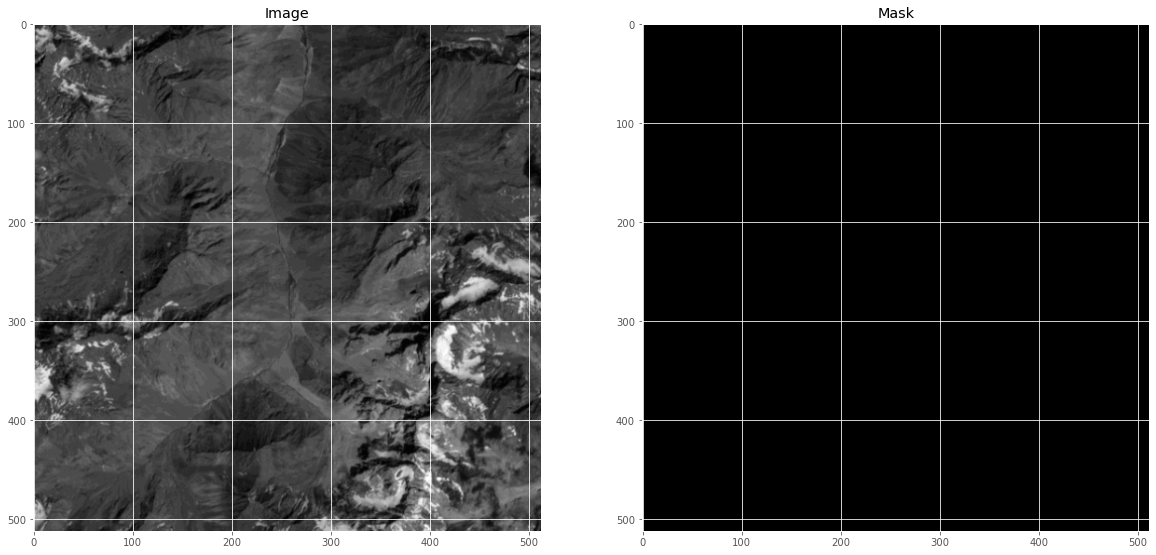

In [9]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # cloud indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating cloud and non-cloud areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [10]:
def conv2d_block(input_tensor,n_filters,name ,padding=(130,130),kernel_size = 3, batchnorm = True):
    # first layer
    x = ZeroPadding2D(padding=padding)(input_tensor)
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'valid',name=name)(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'valid')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def conv2d_block2(input_tensor,n_filters,name ,padding=(128,128),kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same',name=name)(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
               kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [11]:
def get_unet(input_img, padding=(2,2),n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, name='c1',kernel_size = 5, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    '''Input Image: 512X512'''
    '''kernel size 5,padding=130x130: 768x768 > '''
    '''Maxpooling 3x3 > 256x256'''
    
    c2 = conv2d_block2(p1, n_filters * 2, name='c2',kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    '''Input Image: 256X256'''
    '''kernel size 2,padding=same > 256x256'''
    '''Maxpooling 2x2 > 128x128'''
    
    c3 = conv2d_block(p2, n_filters * 4,name='c3', kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    '''Input Image: 128x128'''
    '''kernel size 2,padding=same > 128X128'''
    '''Maxpooling 2x2 > 64x64'''
    
    c4 = conv2d_block(p3, n_filters * 8, name='c4',kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    '''Input Image: 64X64'''
    '''kernel size 2,padding=same > 64X64'''
    '''Maxpooling 2x2 > 32X32'''
    
    c5 = conv2d_block(p4, n_filters * 16, name='c5',kernel_size = 3, batchnorm = batchnorm)
    p5 = MaxPooling2D((2, 2))(c5)
    p5 = Dropout(dropout)(p5)
    '''Input Image: 32X32'''
    '''kernel size 2,padding=same > 32X32'''
    '''Maxpooling 2x2 > 16X16'''
    
    c6 = conv2d_block(p5, n_filters = n_filters * 32, name='c6',kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    '''Input Image: 16x16'''
    u7 = Conv2DTranspose(n_filters * 16, (3, 3), strides = (2, 2), padding = 'same')(c6)
    '''Output : 32x32'''
    u7 = concatenate([u7, c5])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 16, name='c7',kernel_size = 3, batchnorm = batchnorm)
    
    '''Input: 32x32'''
    u8 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c7)
    '''Output: 64x64'''
    u8 = concatenate([u8, c4])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 8, name='c8',kernel_size = 3, batchnorm = batchnorm)
    
    '''Input 64x64'''
    u9 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c8)
    '''Output: 128x128'''
    u9 = concatenate([u9, c3])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 4, name='c9',kernel_size = 3, batchnorm = batchnorm)
    
    u10 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c9)
    u10 = concatenate([u10, c2])
    u10 = Dropout(dropout)(u10)
    c10 = conv2d_block(u9, n_filters * 2,name='c10', kernel_size = 3, batchnorm = batchnorm)
    
    u11 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (4, 4), padding = 'same')(c10)
    u11 = concatenate([u11, c1])
    u11 = Dropout(dropout)(u11)
    c11 = conv2d_block(u9, n_filters * 1, name='c11',kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c11)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [12]:
input_img = Input((im_height, im_width, 4), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.1, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 24, 24, 256), (None, 28, 28, 256)]

In [47]:
os.chdir(r'U:\Training_Data\Training_Images\Test')
from contextlib import redirect_stdout

with open('modelsummary.txt', 'w') as f:
    with redirect_stdout(f):
        model.summary()
#model.summary()

In [45]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(r'U:\Training_Data\CNN_Models\Model_113.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [46]:
t3 = time.time()
results = model.fit(X, y, batch_size=4, epochs=12,validation_split=0.2,shuffle=True)
t4 = time.time()
Total = round((t4-t3)/60, 1)
print('Training complete, took '+str(Total)+' minutes.')

Train on 160 samples, validate on 40 samples
Epoch 1/12
160/160 [==============================] - ETA: 1:27 - loss: 0.6069 - accuracy: 0.60 - ETA: 49s - loss: 0.5741 - accuracy: 0.6200 - ETA: 36s - loss: 0.5541 - accuracy: 0.651 - ETA: 29s - loss: 0.5374 - accuracy: 0.712 - ETA: 25s - loss: 0.5242 - accuracy: 0.734 - ETA: 22s - loss: 0.5114 - accuracy: 0.762 - ETA: 20s - loss: 0.4993 - accuracy: 0.784 - ETA: 18s - loss: 0.4916 - accuracy: 0.785 - ETA: 17s - loss: 0.4830 - accuracy: 0.772 - ETA: 16s - loss: 0.4768 - accuracy: 0.770 - ETA: 15s - loss: 0.4701 - accuracy: 0.764 - ETA: 14s - loss: 0.4636 - accuracy: 0.770 - ETA: 13s - loss: 0.4569 - accuracy: 0.779 - ETA: 12s - loss: 0.4509 - accuracy: 0.791 - ETA: 11s - loss: 0.4443 - accuracy: 0.796 - ETA: 11s - loss: 0.4384 - accuracy: 0.796 - ETA: 10s - loss: 0.4334 - accuracy: 0.796 - ETA: 9s - loss: 0.4282 - accuracy: 0.806 - ETA: 9s - loss: 0.4232 - accuracy: 0.81 - ETA: 8s - loss: 0.4185 - accuracy: 0.81 - ETA: 8s - loss: 0.4137 - 

160/160 [==============================] - ETA: 13s - loss: 0.0319 - accuracy: 0.774 - ETA: 13s - loss: 0.0310 - accuracy: 0.828 - ETA: 12s - loss: 0.0307 - accuracy: 0.845 - ETA: 12s - loss: 0.0306 - accuracy: 0.854 - ETA: 12s - loss: 0.0305 - accuracy: 0.849 - ETA: 11s - loss: 0.0306 - accuracy: 0.850 - ETA: 11s - loss: 0.0303 - accuracy: 0.864 - ETA: 11s - loss: 0.0303 - accuracy: 0.870 - ETA: 10s - loss: 0.0304 - accuracy: 0.853 - ETA: 10s - loss: 0.0303 - accuracy: 0.855 - ETA: 10s - loss: 0.0305 - accuracy: 0.832 - ETA: 9s - loss: 0.0303 - accuracy: 0.845 - ETA: 9s - loss: 0.0301 - accuracy: 0.84 - ETA: 9s - loss: 0.0300 - accuracy: 0.85 - ETA: 8s - loss: 0.0299 - accuracy: 0.86 - ETA: 8s - loss: 0.0298 - accuracy: 0.85 - ETA: 8s - loss: 0.0297 - accuracy: 0.86 - ETA: 7s - loss: 0.0297 - accuracy: 0.85 - ETA: 7s - loss: 0.0296 - accuracy: 0.85 - ETA: 6s - loss: 0.0295 - accuracy: 0.85 - ETA: 6s - loss: 0.0294 - accuracy: 0.85 - ETA: 6s - loss: 0.0293 - accuracy: 0.85 - ETA: 5s - 

KeyboardInterrupt: 

In [ ]:
train_path = r'U:\Training_Data\Training_Images\Test\Unet_Test'
ids = next(os.walk(train_path))[2] # list of names all images in the given path
for i in ids:
    if '.xml' in i:
        ids.remove(i)

try:
    ids.remove('Thumbs.db')
except:
    pass

print("No. of images = ", len(ids))

In [17]:
fixed_list = [0,9,1,2,3,4,5,6,7,8,10,19,11,12,13,14,15,16,17,18,20,29,21,22,23,24,25,26,27,28,
             30,39,31,32,33,34,35,36,37,38,40,49,41,42,43,44,45,46,47,48,50,59,51,52,53,54,55,56,57,58,
             60,69,61,62,63,64,65,66,67,68,70,79,71,72,73,74,75,76,77,78,80,89,81,82,83,84,85,86,87,88,
             90,99,91,92,93,94,95,96,97,98]

new_ids = [ids[i] for i in fixed_list]

In [18]:
X_test = np.zeros((len(ids), im_height, im_width, 4), dtype=np.float32)

In [19]:
# tqdm is used to display the progress bar
import os
os.chdir(r'U:\Training_Data\Training_Images\Test\Unet_Test')
for n, id_ in tqdm_notebook(enumerate(new_ids), total=len(new_ids)):
    # Load images
    img = load_img(id_)
    x_img = img_to_array(img)
    #x_img = gdal_array.LoadFile(id_)
    x_img = resize(x_img, (im_height, im_width, 4), mode = 'constant', preserve_range = True)
    X_test[n] = x_img/255.0

In [ ]:
model = load_model(r'U:\Training_Data\CNN_Models\Model_113.h5')

In [ ]:
model.save_weights(r'U:\Training_Data\CNN_Models\Model_114.h5')

In [47]:
t3 = time.time()
result = model.predict(X_test,batch_size=4)
t4 = time.time()
Total = round((t4-t3)/60, 1)
print('Predictions complete, took '+str(Total)+' minutes.')

Predictions complete, took 0.1 minutes.


32


Text(0.5, 1.0, 'Mask')

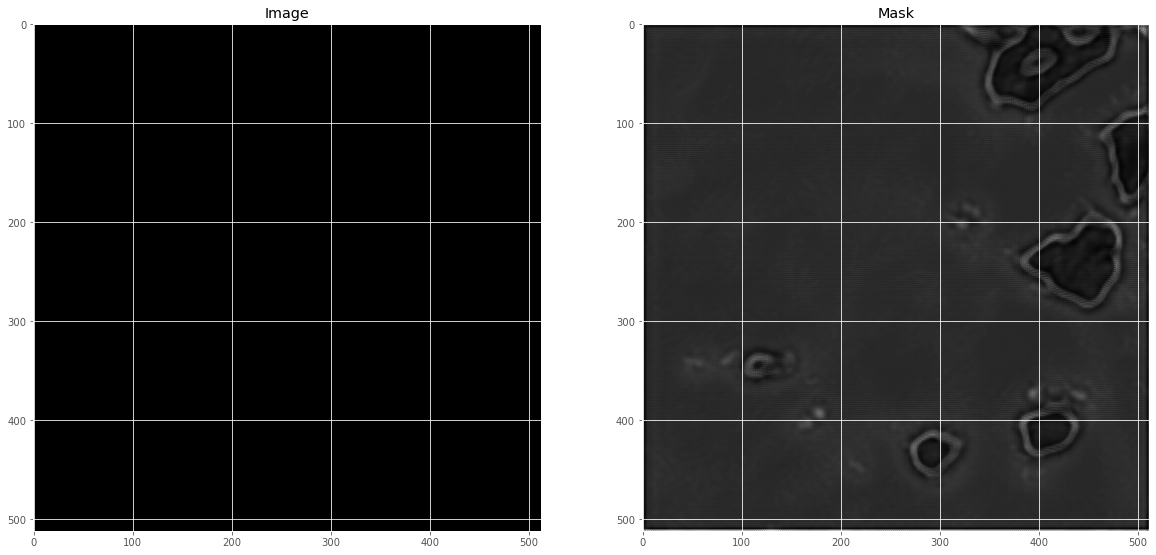

In [65]:
# Visualize any randome image along with the mask
ix = random.randint(0, 99)
print(ix)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_test[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
ax1.set_title('Image')

ax2.imshow(result[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

In [66]:
os.chdir(r'U:\Training_Data\Training_Images\Test\Unet_Test\Result_Mask')
height = 5490
width = 5490
tilesize = 549

for i,k in enumerate(new_ids):
    x_img = resize(result[i], (549, 549, 1),mode = 'constant', preserve_range = True)
    imsave(str(k),x_img)

C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 0_0.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 0_549.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 0_1098.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 0_1647.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 3843_1098.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 3843_1647.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 3843_2196.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_l

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 549_1647.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 549_2196.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_launcher.py:8: UserWarning: 549_2745.png is a low contrast image
  
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\lib\site-packages\ipykernel_laun

In [67]:
os.chdir(r'U:\Training_Data\Training_Images\Test\Unet_Test\Result_Mask')

img_list = glob.glob('*.png')

gdal.Warp(destNameOrDestDS='test1.tif',
          srcDSOrSrcDSTab=img_list,
          resampleAlg='cubic',
          width=5490,
          height=5490,
          format='GTiff',
          )

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000001DB294882D0> >

In [ ]:
os.chdir(r'U:\Training_Data\Training_Images\Test\Unet_Test\Result_Mask\Merged')
sys.path.append(r'C:\Users\jbrown\AppData\Local\conda\conda\envs\gpu\Scripts')
gm = os.path.join('C:\\','Users','jbrown','AppData','Local','conda','conda','envs','neural2','Scripts','gdal_sieve.py')
sieve_command = ["python", gm,'-st','8','-4','-nomask','-of','GTiff','T14QNG_20190127_Mask113.tif','_sieved.tif']
subprocess.call(sieve_command,shell=True)

gm = os.path.join('C:\\','Users','jbrown','AppData','Local','conda','conda','envs','gpu','Scripts','gdal_proximity.py')
prox_command = ["python", gm, '-of','GTiff','-distunits','PIXEL','-maxdist','8','-ot','Byte','-fixed-buf-val','1.0','_sieved.tif','_prox.tif']
subprocess.call(prox_command,shell=True)

gm = os.path.join('C:\\','Users','jbrown','AppData','Local','conda','conda','envs','gpu','Scripts','gdal_calc.py')
merge_command = ["python", gm,"--outfile", "Final_Cloud_Mask113.tif",'-A',"_sieved.tif",'-B','_prox.tif','--calc','A+B']
subprocess.call(merge_command,shell=True)